In [35]:
#import packages
import pickle
import numpy as np
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
from astropy.io import fits
import sys
import math
import os
import csv
from glob import glob
from scipy import interpolate
from scipy.interpolate import griddata
import warnings
warnings.filterwarnings('ignore')

#set plotting defaults to values that make plots look publication ready
cmap = plt.cm.Spectral # color scheme -- visible color spectrum, starting with red as the earliest
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['font.size'] = 14
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 4
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'

# MS+PreMS)

# Access Gaia+APOGEE DR14 cross match 

In [36]:
#load files
#matchedfile = 'GaiaAPOGEE_HugeTable_wDistMod.fits'
matchedfile = 'allstar_HugeTable.fits'
giant_catalog = fits.open(matchedfile)
print("Everything worked")

Everything worked


# Use gaia parallaxes to calculate distance moduli and absolute K magnitudes for each source. Construct J-K vs. M_K color-mag diagram for APOGEE+Gaia(+2MASS) sample, then filter using different parallax/sigma combos

In [37]:
#read in magnitudes and distance modulii
J_app = giant_catalog[1].data['J']
H_app = giant_catalog[1].data['H']
K_app = giant_catalog[1].data['K']
J_app_err = giant_catalog[1].data['J_ERR']
H_app_err = giant_catalog[1].data['H_ERR']
K_app_err = giant_catalog[1].data['K_ERR']
DistMod = giant_catalog[1].data['DistMod']
parallax = giant_catalog[1].data['parallax']
J_minus_K = J_app - K_app

#compute the absolute mags
J_abs = J_app + DistMod
K_abs = K_app + DistMod
H_abs = H_app + DistMod

#error analysis, https://en.wikipedia.org/wiki/Propagation_of_uncertainty
parallax_error = giant_catalog[1].data['parallax_error']
parallax_error_percent = parallax_error/parallax
Distance = 1 / giant_catalog[1].data['Parallax'] 
Distance_err = parallax_error_percent*Distance
DistMod_err = 5 * Distance_err / (Distance * np.log(10))
J_minus_K_err = (J_app_err**2 + K_app_err**2)**(1/2)
K_abs_err = (DistMod_err**2 + K_app_err**2)**(1/2)

#find stars that lie within an acceptable range of colors and mags
realistic = np.where( (J_app - K_app > -1) & (J_app - K_app < 4) & (K_app + DistMod > -10) & (K_app + DistMod < 10) )

In [38]:
#giant_catalog[1].header

[-0.25, 2, 10, -10]

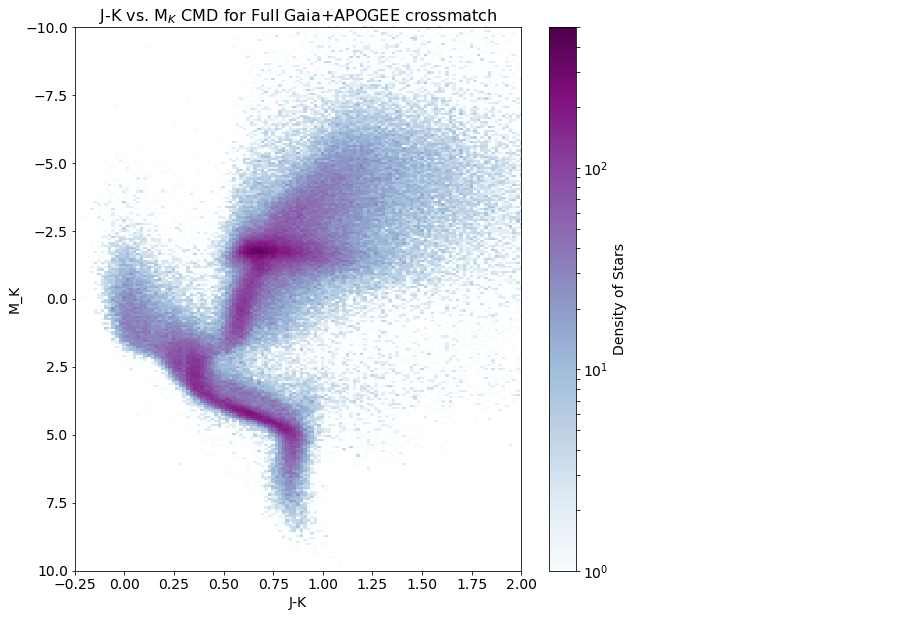

In [39]:
#use the hist2d command to show the density of APOGEE+Gaia stars in the J-K vs. M_K ColorMagnitude Diagram.
JK_CMD = plt.hist2d(J_app[realistic] - K_app[realistic], K_app[realistic] + DistMod[realistic], 
           bins=(250,250), cmap=plt.cm.BuPu, norm=clrs.LogNorm(vmin=(1), vmax=(500)))
plt.colorbar(label = 'Density of Stars')
plt.title('J-K vs. M$_{K}$ CMD for Full Gaia+APOGEE crossmatch' )
xlabel = plt.xlabel('J-K') 
ylabel = plt.ylabel('M_K')
plt.axis([-0.25,2,10,-10])

#plt.savefig('Gaia+APOGEE_J-KvsK_CMD.jpg', bbox_inches='tight')

In [40]:
#include a restriction on the quality of the parallax detection
parallax = giant_catalog[1].data['parallax']
parallax_error = giant_catalog[1].data['parallax_error']

tenSigmaParallax = np.where( ( (parallax / parallax_error) > 10) & (J_app - K_app > -1) & (J_app - K_app < 4) & (K_app + DistMod > -10) & (K_app + DistMod < 10) )

[-0.25, 2, 10, -10]

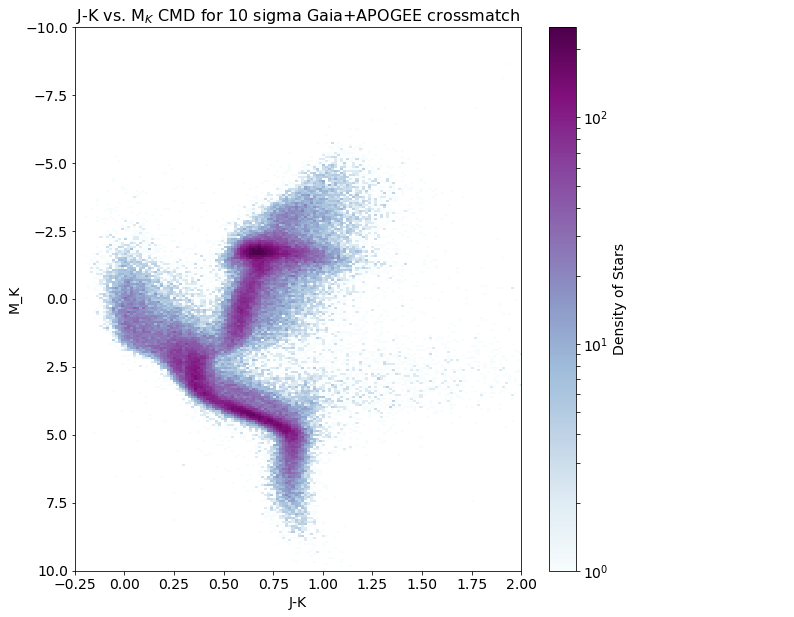

In [41]:
#use the hist2d command to show the density of APOGEE+Gaia stars in the J-K vs. M_K ColorMagnitude Diagram.
JK_CMD = plt.hist2d(J_app[tenSigmaParallax] - K_app[tenSigmaParallax], K_app[tenSigmaParallax] + DistMod[tenSigmaParallax], 
           bins=(250,250), cmap=plt.cm.BuPu, norm=clrs.LogNorm(vmin=(1), vmax=(250)))
plt.colorbar(label = 'Density of Stars')
plt.title('J-K vs. M$_{K}$ CMD for 10 sigma Gaia+APOGEE crossmatch' )
xlabel = plt.xlabel('J-K') 
ylabel = plt.ylabel('M_K')
plt.axis([-0.25,2,10,-10])

#plt.savefig('Gaia+APOGEE_J-KvsK_CMD_10Sigma.jpg', bbox_inches='tight') 

[-0.25, 2, 10, -10]

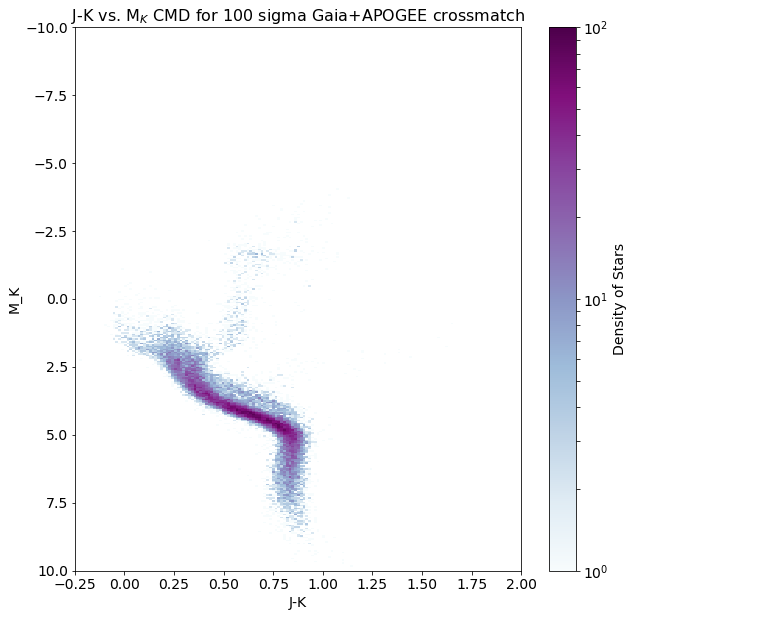

In [42]:
#finally, restrict to 100 sigma parallax detections
hundredSigmaParallax = np.where( ( (parallax / parallax_error) > 100) & (J_app - K_app > -1) & (J_app - K_app < 4) & (K_app + DistMod > -10) & (K_app + DistMod < 10) )

#use the hist2d command to show the density of APOGEE+Gaia stars in the J-K vs. M_K ColorMagnitude Diagram.
JK_CMD = plt.hist2d(J_app[hundredSigmaParallax] - K_app[hundredSigmaParallax], K_app[hundredSigmaParallax] + DistMod[hundredSigmaParallax], 
           bins=(250,250), cmap=plt.cm.BuPu, norm=clrs.LogNorm(vmin=(1), vmax=(100)))
plt.colorbar(label = 'Density of Stars')
plt.title('J-K vs. M$_{K}$ CMD for 100 sigma Gaia+APOGEE crossmatch' )
xlabel = plt.xlabel('J-K') 
ylabel = plt.ylabel('M_K')
plt.axis([-0.25,2,10,-10])

#plt.savefig('Gaia+APOGEE_J-KvsK_CMD_100Sigma.jpg', bbox_inches='tight') 

# MAIN SEQUENCE COLUMN

# Filter young cluster plates OUT of the main sequence sample

In [43]:
# Getting the field (region) indices
One91_12 = np.where(giant_catalog[1].data['field']=='191-12')
K2_C4_168_21 = np.where(giant_catalog[1].data['field']=='K2_C4_168-21')
TWO03PLUS04 = np.where(giant_catalog[1].data['field']=='203+04')
IC348 = np.where(giant_catalog[1].data['field']=='IC348')
LAMBDAORI_A = np.where(giant_catalog[1].data['field']=='LAMBDAORI-A')
LAMBDAORI_B = np.where(giant_catalog[1].data['field']=='LAMBDAORI-B')
N1333 = np.where(giant_catalog[1].data['field']=='N1333')
ORIONA = np.where(giant_catalog[1].data['field']=='ORIONA')
ORIONB = np.where(giant_catalog[1].data['field']=='ORIONB')
ORIONB_A = np.where(giant_catalog[1].data['field']=='ORIONB-A')
ORIONB_B = np.where(giant_catalog[1].data['field']=='ORIONB-B')
ORIONC = np.where(giant_catalog[1].data['field']=='ORIONC')
ORIOND = np.where(giant_catalog[1].data['field']=='ORIOND')
ORIONE = np.where(giant_catalog[1].data['field']=='ORIONE')
ORIONOB1AB_F = np.where(giant_catalog[1].data['field']=='ORIONOB1AB-F')
PLEIADES_E = np.where(giant_catalog[1].data['field']=='PLEIADES-E')
Pleiades = np.where(giant_catalog[1].data['field']=='Pleiades')

In [44]:
# The indices of MS and Pre-MS stars 
All_Indices = np.where(giant_catalog[1].data['field'])
PMS_Indices = np.unique(np.concatenate([One91_12,  K2_C4_168_21,  TWO03PLUS04,  
                IC348,  LAMBDAORI_A,  LAMBDAORI_B,  N1333,  ORIONA,  ORIONB,  
                ORIONB_A,  ORIONB_B,  ORIONC,  ORIOND,  ORIONE,  ORIONOB1AB_F,
                PLEIADES_E,  Pleiades], axis = 1))
MS_Indices = np.setdiff1d(All_Indices,PMS_Indices)

print("Double checking that this indexing works, this should equal zero")
print('ALL - PMS - MS: ', np.size(All_Indices)-(np.size(PMS_Indices)+np.size(MS_Indices)))

Double checking that this indexing works, this should equal zero
ALL - PMS - MS:  0


# Working on the Main_Sequence stars

In [45]:
#read in magnitudes and distance modulii
J_app = giant_catalog[1].data['J']
H_app = giant_catalog[1].data['H']
K_app = giant_catalog[1].data['K']
J_app_err = giant_catalog[1].data['J_ERR']
H_app_err = giant_catalog[1].data['H_ERR']
K_app_err = giant_catalog[1].data['K_ERR']
DistMod = giant_catalog[1].data['DistMod']
parallax = giant_catalog[1].data['parallax']
J_minus_K = J_app - K_app
g = giant_catalog[1].data['gmag_pan']
r = giant_catalog[1].data['rmag_pan']
ra_APOGEE = giant_catalog[1].data['ra_APOGEE']
dec_APOGEE = giant_catalog[1].data['dec_APOGEE']
AP_IDS = giant_catalog[1].data['APOGEE_ID']
Source_IDS = giant_catalog[1].data['source_id']

#compute the absolute mags
J_abs = J_app + DistMod
K_abs = K_app + DistMod
H_abs = H_app + DistMod

#error analysis, https://en.wikipedia.org/wiki/Propagation_of_uncertainty
parallax_error = giant_catalog[1].data['parallax_error']
parallax_error_percent = parallax_error/parallax
Distance = 1 / giant_catalog[1].data['Parallax']
Distance_err = parallax_error_percent*Distance
DistMod_err = 5 * Distance_err / (Distance * np.log(10))
J_minus_K_err = (J_app_err**2 + K_app_err**2)**(1/2)
K_abs_err = (DistMod_err**2 + K_app_err**2)**(1/2)

In [46]:
#filtering the batch of MS stars
J_app_MS = J_app[MS_Indices]
H_app_MS = H_app[MS_Indices]
K_app_MS = K_app[MS_Indices]
J_abs_MS = J_abs[MS_Indices]
K_abs_MS = K_abs[MS_Indices]
H_abs_MS = H_abs[MS_Indices]
g_MS = g[MS_Indices]
r_MS = r[MS_Indices]
DistMod_MS = DistMod[MS_Indices]
parallax_MS = parallax[MS_Indices]
ra_APOGEE_MS = ra_APOGEE[MS_Indices]
dec_APOGEE_MS = dec_APOGEE[MS_Indices]
AP_IDS_MS = AP_IDS[MS_Indices]
Source_IDS_MS = Source_IDS[MS_Indices]

parallax_error_MS = parallax_error[MS_Indices]
parallax_error_percent_MS = parallax_error_percent[MS_Indices]
Distance_MS = Distance[MS_Indices]
Distance_err_MS = Distance_err[MS_Indices]
DistMod_err_MS = DistMod_err[MS_Indices]
J_minus_K_err_MS =  J_minus_K_err[MS_Indices]
K_abs_err_MS = K_abs_err[MS_Indices]
J_minus_K_MS = J_minus_K[MS_Indices]

In [47]:
#Every equation used in the next cell has calibration bounds, set here
t_eff_bounds = np.where((0.7 < (J_app_MS-K_app_MS))   &  ((J_app_MS-K_app_MS) < 1.05)&  (3.37 < (g_MS-K_app_MS))   &  ((g_MS-K_app_MS)<8.46))
print(np.size(t_eff_bounds))
mass_bounds = np.where((K_abs_MS<10) & (K_abs_MS>5))
print(np.size(mass_bounds))

finite_bounds = np.where(np.isfinite(g_MS) & np.isfinite(r_MS))
print(np.size(finite_bounds))

calibration_index = np.intersect1d(np.intersect1d(t_eff_bounds, mass_bounds), finite_bounds)


J_app_MS = J_app_MS[calibration_index]
H_app_MS = H_app_MS[calibration_index]
K_app_MS = K_app_MS[calibration_index]
J_abs_MS = J_abs_MS[calibration_index]
K_abs_MS = K_abs_MS[calibration_index]
H_abs_MS = H_abs_MS[calibration_index]
g_MS = g_MS[calibration_index]
r_MS = r_MS[calibration_index]
DistMod_MS = DistMod_MS[calibration_index]
parallax_MS = parallax_MS[calibration_index]
ra_APOGEE_MS = ra_APOGEE_MS[calibration_index]
dec_APOGEE_MS = dec_APOGEE_MS[calibration_index]
AP_IDS_MS = AP_IDS_MS[calibration_index]
Source_IDS_MS = Source_IDS_MS[calibration_index]

70604
9212
229632


In [48]:
# Inferring metallicity from photometry. Eqn 1, page 8 from https://arxiv.org/pdf/1502.07460.pdf
C1 = np.array([-14.2959, 0.0519, 29.5926, -0.0529, -17.6762, 0.7032])
Fe_H = C1[0] + C1[1]*(g_MS-K_app_MS) + C1[2]*(J_app_MS-K_app_MS) + (C1[3] * (g_MS-K_app_MS)**2) + (C1[4] * (J_app_MS-K_app_MS)**2) + C1[5] * (g_MS-K_app_MS) * (J_app_MS-K_app_MS)




#Inferring mass in units of solar mass from M_K. Eqn 11, page 26 of https://arxiv.org/pdf/1608.04775.pdf
C2 = np.array([.2311, -.1352, .0400, .0038, -.0032])
x = 7.5
Mass = C2[0] + C2[1]*(K_abs_MS-x) + C2[2]*(K_abs_MS-x)**2 + C2[3]*(K_abs_MS-x)**3 + C2[4]*(K_abs_MS-x)**4




# Determining Teff. Eqns 6 and 7, page 11, from https://arxiv.org/pdf/1501.01635.pdf
C3 = np.array([2.532, -1.319, 0.4449, -.07151, 0.004333, 0.05629])
x = r_MS - J_app_MS
T_eff = 3500 * (C3[0] + C3[1]*x + C3[2]*x**2 + C3[3]*x**3 + C3[4]*x**4 + C3[5]*(Fe_H))

x2 = r_MS - J_app_MS
C4 = np.array([2.151, -1.092,0.3767, -0.06292, 0.003950, 0.1697, 0.03106])
T_eff2 = 3500 * (C4[0] + C4[1]*x2 + C4[2]*x2**2 + C4[3]*x2**3 + C4[4]*x2**4 + C4[5]*(J_app_MS-H_app_MS) + C4[6]*(J_app_MS-H_app_MS)**2)


#Using Teff and [Fe/H] to assign log g to stars. Eqn 5, page 7 from https://arxiv.org/pdf/1710.10259.pdf
log_g = 7.912 - 0.1880 * Fe_H - 1.335e-3 * T_eff + 1.313e-7 * ( T_eff ** 2 )
log_g2 = 7.912 - 0.1880 * Fe_H - 1.335e-3 * T_eff2 + 1.313e-7 * ( T_eff2 ** 2 )

#  Check for consistency with parameters from detailed analysis of APOGEE spectra

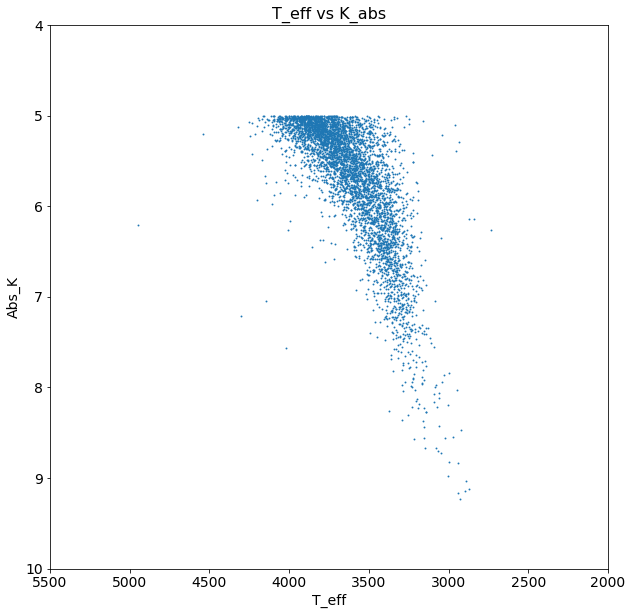

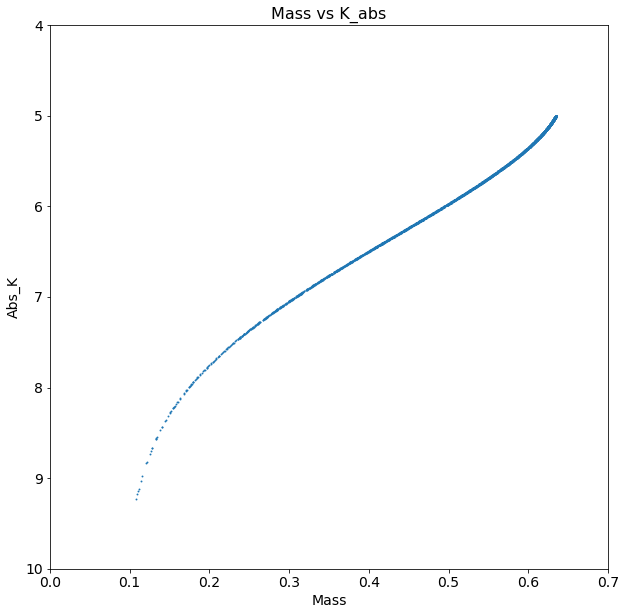

In [49]:
plt.figure()
plt.title("T_eff vs K_abs")
plt.ylabel("Abs_K")
plt.xlabel("T_eff")
plt.xlim(5500,2000)
plt.ylim(10,4)
plt.scatter(T_eff, K_abs_MS, s = 0.8)
plt.show()
#fit isochrones

plt.figure()
plt.title("Mass vs K_abs")
plt.ylabel("Abs_K")
plt.xlabel("Mass")
plt.xlim(0,.7)
plt.ylim(10,4)
plt.scatter(Mass,K_abs_MS, s = 0.8)
plt.show()

In [50]:
#ranges of our values
print("Min max of Fe_H:", min(Fe_H), ",", max(Fe_H))
print("Min max of Mass:", min(Mass), ",", max(Mass))
print("Min max of T_eff:", min(T_eff), ",", max(T_eff))
print("Min max of log_g:", min(log_g), ",", max(log_g))

Min max of Fe_H: -0.9808347 , 0.318398
Min max of Mass: 0.10804131490110201 , 0.6347170651933377
Min max of T_eff: 2731.0208 , 12477.663
Min max of log_g: 4.489062 , 11.660149


In [51]:
#send labels that we already have to marina: http://docs.astropy.org/en/stable/io/fits/
col1 = fits.Column(name='ap_id', format='20A', array=AP_IDS_MS)
col2 = fits.Column(name='source_id', format='20A', array=Source_IDS_MS)
col3 = fits.Column(name='Fe_H', format='E', array=Fe_H)
col4 = fits.Column(name='Mass', format='E', array=Mass)
col5 = fits.Column(name='T_eff', format='E', array=T_eff)
#col6 = fits.Column(name='T_eff2', format='E', array=T_eff2)
col7 = fits.Column(name='log_g', format='E', array=log_g)
#col8 = fits.Column(name='log_g2', format='E', array=log_g2)
col9 = fits.Column(name='J_app', format='E', array=J_app_MS)
col10 = fits.Column(name='K_app', format='E', array=K_app_MS)
col11 = fits.Column(name='H_app', format='E', array=H_app_MS)
col12 = fits.Column(name='J_abs', format='E', array=J_abs_MS)
col13 = fits.Column(name='K_abs', format='E', array=K_abs_MS)
col14 = fits.Column(name='H_abs', format='E', array=H_abs_MS)
col15 = fits.Column(name='g', format='E', array=g_MS)
col16 = fits.Column(name='r', format='E', array=r_MS)
col17 = fits.Column(name='DistMod', format='E', array=DistMod_MS)
col18 = fits.Column(name='parallax', format='E', array=parallax_MS)
col19 = fits.Column(name='ra_APOGEE', format='E', array=ra_APOGEE_MS)
col20 = fits.Column(name='dec_APOGEE', format='E', array=dec_APOGEE_MS)


cols = fits.ColDefs([col1, col2, col3, col4, col5, col7,col9, col10, col11, col12, col13, col14, col15, col16,col17, col18, col19, col20])
hdu_export = fits.BinTableHDU.from_columns(cols)
#hdu_export.writeto('MS_Labels_Nov_18th_Corrected.fits')

In [52]:
#Sending the MS labels to Chad

#pulling data that we already have from the fits file
vmic = giant_catalog[1].data['VMICRO'][MS_Indices]
vmic = vmic[calibration_index]
vmac = giant_catalog[1].data['VMACRO'][MS_Indices]
vmac = vmac[calibration_index]


#matching the order of the payne labels file, 25 columns
AP_IDS_export = AP_IDS_MS
ra_APOGEE_export = ra_APOGEE_MS
dec_APOGEE_export = dec_APOGEE_MS
T_eff_export = T_eff
log_g_export = log_g
vmic_export = vmic
CH_export = np.zeros(np.size(calibration_index))
NH_export = np.zeros(np.size(calibration_index))
OH_export = np.zeros(np.size(calibration_index))
MgH_export = np.zeros(np.size(calibration_index))
AlH_export = np.zeros(np.size(calibration_index))
SiH_export = np.zeros(np.size(calibration_index))
SH_export = np.zeros(np.size(calibration_index))
KH_export = np.zeros(np.size(calibration_index))
CaH_export = np.zeros(np.size(calibration_index))
TiH_export = np.zeros(np.size(calibration_index))
CrH_export = np.zeros(np.size(calibration_index))
MnH_export = np.zeros(np.size(calibration_index))
FeH_export = Fe_H
Nih_export = np.zeros(np.size(calibration_index))
CuH_export = np.zeros(np.size(calibration_index))
C12C13_export = np.zeros(np.size(calibration_index))
vmac_export = vmac
chi2_export = np.zeros(np.size(calibration_index))
quality_flag_export = np.repeat("DNE", np.size(calibration_index))
total_export = np.c_[AP_IDS_export, ra_APOGEE_export, dec_APOGEE_export, T_eff_export,log_g_export,
                    vmic_export, CH_export, NH_export,OH_export,MgH_export,
                     AlH_export,SiH_export, SH_export,KH_export,CaH_export,
                     TiH_export,CrH_export,MnH_export,FeH_export,Nih_export,
                     CuH_export,C12C13_export,vmac_export,chi2_export,quality_flag_export]

#fmt = '%20s %10s %10s %8s %3s %3s %3s %s %s %s %20s %20s %20s %20s %20s %20s %20s %20s %20s %20s %20s %20s %20s %20s %20s'
fmt = "%s"
header = "# APOGEE_ID RA[deg] Dec[deg] Teff[K] Logg vmic[km/s] CH NH OH MgH AlH SiH SH KH CaH TiH CrH MnH FeH NiH CuH C12C13 vmac[km/s] chi2_R quality_flag"
np.savetxt('MS_labels.txt', total_export ,header = header, delimiter='   ', fmt=fmt) 

# Working on the Pre-Main_Sequnce Stars

# Using PreMS indices, and additional filter to remove non-members from the sample

In [53]:
#Using Dr. Kounkel's list to further filter down PMS stars.
member_file = open('ysos.txt', 'r')
members = np.array(member_file.read().split('\n'))
PMS_IDs = giant_catalog[1].data['APOGEE_ID'][PMS_Indices]
member_overlap = np.array(list((set(members) & set(PMS_IDs))))

#Sifting the dating using the PMS_indices
J_app_PMS = J_app[PMS_Indices]
H_app_PMS = H_app[PMS_Indices]
K_app_PMS = K_app[PMS_Indices]
J_abs_PMS = J_abs[PMS_Indices]
K_abs_PMS = K_abs[PMS_Indices]
H_abs_PMS = H_abs[PMS_Indices]
DistMod_PMS = DistMod[PMS_Indices]
parallax_PMS = parallax[PMS_Indices]
ra_APOGEE_PMS = ra_APOGEE[PMS_Indices]
dec_APOGEE_PMS = dec_APOGEE[PMS_Indices]
AP_IDS_PMS = AP_IDS[PMS_Indices]
Source_IDS_PMS = Source_IDS[PMS_Indices]
g_PMS = g[PMS_Indices]

#error analysis
parallax_error_PMS = parallax_error[PMS_Indices]
parallax_error_percent_PMS = parallax_error_percent[PMS_Indices]
Distance_PMS = Distance[PMS_Indices]
Distance_err_PMS = Distance_err[PMS_Indices]
DistMod_err_PMS = DistMod_err[PMS_Indices]
J_minus_K_err_PMS =  J_minus_K_err[PMS_Indices]
K_abs_err_PMS = K_abs_err[PMS_Indices]
J_minus_K_PMS = J_minus_K[PMS_Indices]


#From the already sifted data, apply the member_index.
member_index_file = open('member_index.txt', 'r')
member_index = (np.array(member_index_file.read().split('\n'))[:-1]).astype(int)

#Sifting the dating using the PMS_indices
J_app_PMSM = J_app_PMS[member_index]
H_app_PMSM = H_app_PMS[member_index]
K_app_PMSM = K_app_PMS[member_index]
J_abs_PMSM = J_abs_PMS[member_index]
K_abs_PMSM = K_abs_PMS[member_index]
H_abs_PMSM = H_abs_PMS[member_index]
DistMod_PMSM = DistMod_PMS[member_index]
parallax_PMSM = parallax_PMS[member_index]
ra_APOGEE_PMSM = ra_APOGEE_PMS[member_index]
dec_APOGEE_PMSM = dec_APOGEE_PMS[member_index]
AP_IDS_PMSM = AP_IDS_PMS[member_index]
Source_IDS_PMSM = Source_IDS_PMS[member_index]
g_PMSM = g_PMS[member_index]

#error analysis
parallax_error_PMSM = parallax_error_PMS[member_index]
parallax_error_percent_PMSM = parallax_error_percent_PMS[member_index]
Distance_PMSM = Distance_PMS[member_index]
Distance_err_PMSM = Distance_err_PMS[member_index]
DistMod_err_PMSM = DistMod_err_PMS[member_index]
J_minus_K_err_PMSM =  J_minus_K_err_PMS[member_index]
K_abs_err_PMSM = K_abs_err_PMS[member_index]
J_minus_K_PMSM = J_minus_K_PMS[member_index]

# Filtering out the stars with disk excess

In [54]:
disk_file = open('disks.txt', 'r')
disk_list = []
for line in disk_file:
    line = line.rstrip('\n')
    disk_list.append(line)
disk_list = np.array(disk_list)
disk_overlap = np.array(list((set(disk_list) & set(AP_IDS_PMSM))))

#Using this to get a memeber_index
export = []
for counter1,value1 in enumerate(disk_overlap):  
    for counter2, value2 in enumerate(AP_IDS_PMSM):
        if value2 == value1:
            export.append(counter2)
            
np.savetxt('disk_index.txt', export, fmt='%i', delimiter=',')   # X is an array

In [55]:
disk_index_file = open('disk_index.txt', 'r')
disk_index = (np.array(disk_index_file.read().split('\n'))[:-1]).astype(int)

non_disk_index = np.zeros(AP_IDS_PMSM.shape,dtype=bool)
non_disk_index[disk_index] = True
non_disk_index = ~non_disk_index

[False False False ... False False False]


In [56]:
#Sifting the dating using the PMS_indices
J_app_PMSMD = J_app_PMSM[non_disk_index]
H_app_PMSMD = H_app_PMSM[non_disk_index]
K_app_PMSMD = K_app_PMSM[non_disk_index]
J_abs_PMSMD = J_abs_PMSM[non_disk_index]
K_abs_PMSMD = K_abs_PMSM[non_disk_index]
H_abs_PMSMD = H_abs_PMSM[non_disk_index]
DistMod_PMSMD = DistMod_PMSM[non_disk_index]
parallax_PMSMD = parallax_PMSM[non_disk_index]
ra_APOGEE_PMSMD = ra_APOGEE_PMSM[non_disk_index]
dec_APOGEE_PMSMD = dec_APOGEE_PMSM[non_disk_index]
AP_IDS_PMSMD = AP_IDS_PMSM[non_disk_index]
Source_IDS_PMSMD = Source_IDS_PMSM[non_disk_index]
g_PMSMD = g_PMSM[non_disk_index]

#error analysis
parallax_error_PMSMD = parallax_error_PMSM[non_disk_index]
parallax_error_percent_PMSMD = parallax_error_percent_PMSM[non_disk_index]
Distance_PMSMD = Distance_PMSM[non_disk_index]
Distance_err_PMSMD = Distance_err_PMSM[non_disk_index]
DistMod_err_PMSMD = DistMod_err_PMSM[non_disk_index]
J_minus_K_err_PMSMD =  J_minus_K_err_PMSM[non_disk_index]
K_abs_err_PMSMD = K_abs_err_PMSM[non_disk_index]
J_minus_K_PMSMD = J_minus_K_PMSM[non_disk_index]

# Construct K-8 micron color and use

In [57]:
#importing the pickle file
with open("parsecgrid.pickle", 'rb') as file:
    data = pickle.load(file, encoding ='latin1')
data = data[0]

AGE = np.array(data[0])
MINI = np.array(data[1])
MASS = np.array(data[2])
TEFF = np.array(data[3])
LOGG = np.array(data[4])
GMAG = np.array(data[5])
GB = np.array(data[6])
GR = np.array(data[7])
BV = np.array(data[8])
JMAG = np.array(data[9])
HMAG = np.array(data[10])
KMAG = np.array(data[11])
GBR = np.array(data[12])
LL = np.array(data[13])

In [58]:
#widdling down the data, see Dr. Kounkels .pro file. I've copied what she's doing
a=np.where(AGE < 4e7)[0]
b=np.where(MINI < 20)[0]
JMK = (JMAG-KMAG)[b,:]
JMK = JMK[:,a]
K_abs_model = KMAG[b,:]
K_abs_model = K_abs_model[:,a]
x=J_minus_K_PMSMD
teff = []
delta_list = []
TEFF_trimed = TEFF[b,:]
TEFF_trimed = TEFF_trimed[:,a]
LOGG_trimmed = LOGG[b,:]
LOGG_trimmed = LOGG_trimmed[:,a]
print(np.shape(JMAG))
print(np.shape(JMK))

(1500, 300)
(1174, 181)


In [59]:
masses = np.arange(0.1,1,.1) 
ages = [1e6, 5e6,1e7,5e7,1e8,5e8,1e9]
def find_nearest_index(array, values):
    idx = []
    for x in range(np.size(values)):
        idx.append((np.abs(array - values[x])).argmin())
    return np.array(idx)

mass_idx = find_nearest_index(MINI, masses)
ages_idx = find_nearest_index(AGE, ages)

TEFF_T = np.transpose(TEFF)
KMAG_T = np.transpose(KMAG)
MASS_T = np.transpose(MASS)
GBR_T = np.transpose(GBR)

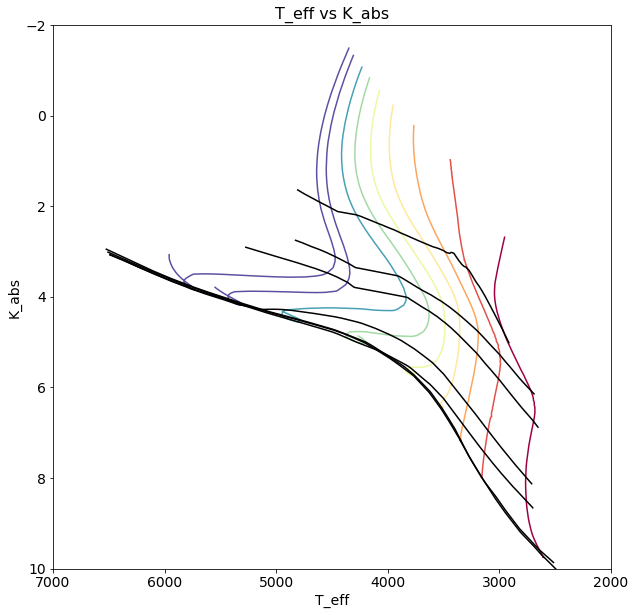

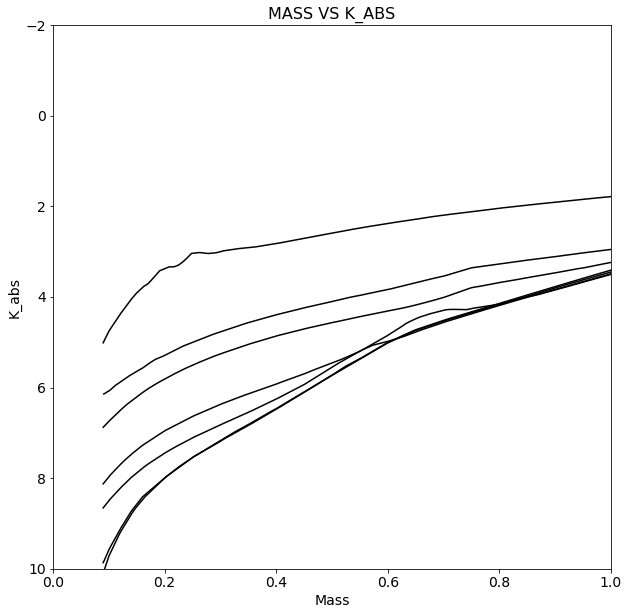

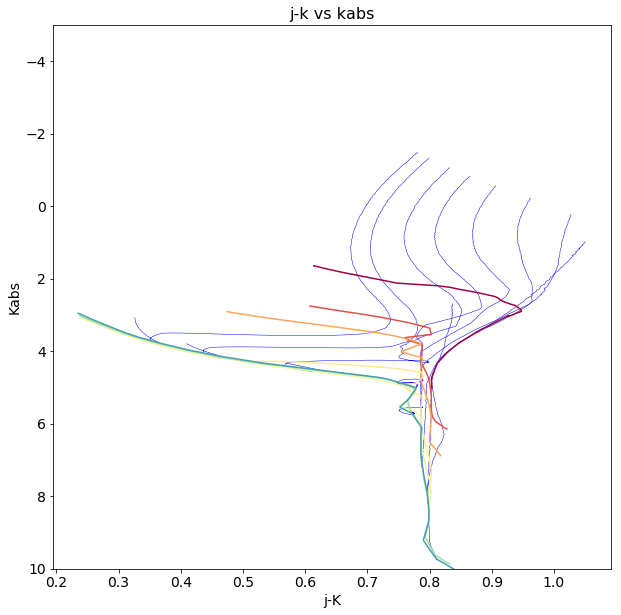

In [64]:
plt.figure()
plt.title("T_eff vs K_abs")
plt.xlabel("T_eff")
plt.ylabel("K_abs")
plt.xlim(7000,2000)
plt.ylim(10,-2)
cut = 550

for x in range(np.size(mass_idx)):
    plt.plot(TEFF[mass_idx[x]],KMAG[mass_idx[x]],c = cmap(x/float(7)))
for x in range(np.size(ages_idx)):
    plt.plot(TEFF_T[ages_idx[x]][:cut],KMAG_T[ages_idx[x]][:cut],c = 'black')
plt.show()


plt.figure()
plt.title("MASS VS K_ABS")
plt.xlabel("Mass")
plt.ylabel("K_abs")
plt.xlim(0,1)
plt.ylim(10,-2)
for x in range(np.size(ages_idx)):
    plt.plot(MASS_T[ages_idx[x]][:cut],KMAG_T[ages_idx[x]][:cut],c = 'black')
plt.show()


plt.figure()
plt.title("j-k vs kabs")
plt.xlabel("j-K")
plt.ylabel("Kabs")
plt.ylim(10,-5)
for x in range(np.size(mass_idx)):
    plt.plot((JMAG-KMAG)[mass_idx[x]],KMAG[mass_idx[x]],c = 'blue', lw=0.5)
for x in range(np.size(ages_idx)):
    plt.plot((JMAG-KMAG).T[ages_idx[x]][:cut],KMAG_T[ages_idx[x]][:cut],c = cmap(x/float(7)))
plt.show()

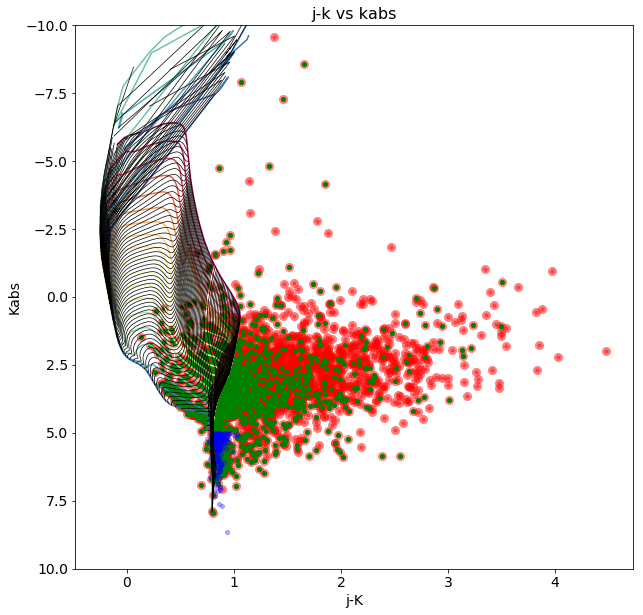

In [69]:
plt.figure()
plt.title("j-k vs kabs")
plt.xlabel("j-K")
plt.ylabel("Kabs")
plt.ylim(10,-10)
for x in range(math.ceil(len(JMK.T)/10)): #for ages
    plt.plot(JMK.T[x*10], K_abs_model.T[x*10], c = cmap(x/float(math.ceil(len(JMK.T)/10))))
for x in range(math.ceil(len(JMK)/10)): #for Mini
    plt.plot(JMK[x*10], K_abs_model[x*10], c = 'black', lw=0.7)

'''These points fit horribly! I've sent the data to Dr. Kounkel for a double check.
FOLLOW UP: She said the isochrones are a bad fit for this data.
She is going to get us new isochrones, in the mean time use https://arxiv.org/pdf/1805.04649.pdf
page 9. (t grid’s MG by +0.2 mag, and [GB − GR] by +0.15 mag) to get something semi-functional and to
test out routines'''
#The PMS stars BEFORE the disk filter
for x in range(len(J_minus_K_PMSM)):
    plt.scatter(J_minus_K_PMSM[x],K_abs_PMSM[x], lw = 5, c = 'red',alpha=0.5)  
    

#The PMS stars AFTER the disk filter
for x in range(len(J_minus_K_PMSMD)):
    plt.scatter(J_minus_K_PMSMD[x],K_abs_PMSMD[x], lw = 1, c = 'green')  


####These points fit well!            
J_minus_K_MS = J_abs_MS-K_abs_MS
for x in range(200):
    plt.scatter((J_minus_K_MS)[x*3],K_abs_MS[x*3], lw = 1, c = 'blue',alpha=0.3)

In [67]:
#we have a close age, and a close mass. Use this to infer teff and logg
TEFF_func = interpolate.interp2d(AGE[a], MINI[b], TEFF_trimed)#, kind='cubic')
LOGG_func = interpolate.interp2d(AGE[a], MINI[b], LOGG_trimmed)#, kind='cubic')


#for i in range(len(J_minus_K_PMS)):
for i in range(5):
    if(np.isfinite(J_minus_K_PMS[i]) & np.isfinite(K_abs_PMS[i])):
        offx = 0.001
        offy = 0.001
        where = np.where(K_abs_model<-100000000)       
        while(len(where[0])==0):
            where = np.where((abs(JMK-J_minus_K_PMS[i])<offx) & (abs(K_abs_model - K_abs_PMS[i])<offy))
            offx = offx*2
            offy = offy*2
            
        mass_avg = np.mean(MINI[where[0]])
        age_avg = np.mean(AGE[where[1]])   
        T_label = TEFF_func(age_avg, mass_avg)
        #logg_label = LOGG_func(mass_avg, age_avg)
        print(T_label)
        best_JMK = JMK[where[0][0]][where[1][0]]
        best_K_abs = K_abs_model[where[0][0]][where[1][0]]
        delta_j_minus_k = (best_JMK - J_minus_K_PMS[i])/J_minus_K_err_PMS[i]
        delta_K_abs =(best_K_abs - K_abs_PMS[i])/K_abs_err_PMS[i]
        delta = (delta_j_minus_k**2 + delta_K_abs**2)**(1/2)
        delta_list.append(delta)
        teff.append(T_label)
    else:
        delta_list.append(-1)
        teff.append("ERR")

[nan]
[nan]
[nan]
[nan]
[nan]


In [178]:
#####Everything below this is garbage/test stuff



col1 = fits.Column(name='J_minus_K_PMS', format='20A', array=J_minus_K_PMS)
col2 = fits.Column(name='K_abs_PMS', format='20A', array=K_abs_PMS)
col3 = fits.Column(name='J_minus_K_MS', format='20A', array=J_minus_K_MS)
col4 = fits.Column(name='K_abs_MS', format='20A', array=K_abs_MS)
cols = fits.ColDefs([col1, col2, col3, col4])
hdu_export = fits.BinTableHDU.from_columns(cols)
hdu_export.writeto('K_abs_and_j-k.fits')

In [26]:
#Using this to get a memeber_index
export = []
for x,z in enumerate(member_overlap):  
    for i, j in enumerate(PMS_IDs):
        if j == z:
            export.append(i)
            
np.savetxt('member_index.txt', export, fmt='%i', delimiter=',')   # X is an array

In [172]:
file = 'MS_Labels_w_source.fits'
test_hdu = fits.open(file)
#print(test_hdu[1].header)

In [16]:

#Everything below this line is the recycle bin
def find_indices(ID1,ID2,ID_min):
    ID2_index = []
    ID1_index = []
    index = 0
    for x in range(len(ID2)):
        if ID2[x] == ID1[index]:
            ID1_index.append(index)
            ID2_index.append(x)
            index += 1
        elif ID2[x] > ID1[index]:
            index += 1
        if (x+1>=ID_min):
            return ID1_index, ID2_index
    return ID1_index, ID2_index



def make_JmK_vs_MK(xaxis, yaxis, title, xtitle, ytitle):
    plt.title(title)
    plt.xlabel(xtitle)
    plt.ylabel(ytitle)
    plt.ylim(10,-15)
    plt.xlim(-2.5,5)
    plt.scatter(xaxis, yaxis, s=0.01)
    plt.show()

In [35]:
#demonstrating the sort function works, but it doesn't entirely. Last index
test1 = [1,2,4,5,6,8,10,11,14]
test2 = [1,3,4,5,6,7,8,10,11,12,14,15]
testlen = min(len(test1), len(test2))
print(testlen)
test1 = np.sort(test1)
test2 = np.sort(test2)
test_index1, test_index2 = find_indices(test1,test2,testlen)

new1 = test1[test_index1]
new2 = test2[test_index2]

print(new1)
print(new2)


9
[ 1  4  5  6  8 10 11]
[ 1  4  5  6  8 10 11]


2014-08-10
XTENSION= 'IMAGE   '           / IMAGE extension                                BITPIX  =                  -32 / Number of bits per data pixel                  NAXIS   =                    1 / Number of data axes                            NAXIS1  =                 8575 /                                                PCOUNT  =                    0 / No Group Parameters                            GCOUNT  =                    1 / One Data Group                                 CRVAL1  =        4.17900000000 /                                                CDELT1  =    6.00000000000E-06 /                                                CRPIX1  =                    1 /                                                CTYPE1  = 'LOG-LINEAR'         /                                                DC-FLAG =                    1 /                                                BUNIT   = 'Flux (10^-17 erg/s/cm^2/Ang)' /                                      END                          

(15960, 16000)

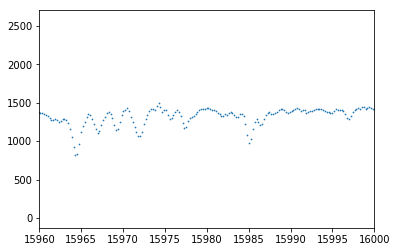

In [5]:
#A random fits file from Dr. Covey's server
random = "apStarC-r5-2M21432388+4209512.fits"
hdu = fits.open(random)


'''hdu[0].header['NAME'], where you can pull anything 
named NAME from the header file. See link (in slack) for list of NAME's. 
 https://data.sdss.org/datamodel/files/APOGEE_REDUX/APRED_VERS
/APSTAR_VERS/TELESCOPE/LOCATION_ID/apStar.html'''
date = hdu[0].header['DATE']
print(date)

#the header, showing starting wavelength and other
fluxhead = hdu[1].header 
print(fluxhead)
#the data
flux = hdu[1].data
print("\n", flux)

#relevant information (starting wavelength, and conversion) found in header
wavelength = 10.**(4.179+6e-6*np.arange(0,len(flux),1))

plt.scatter(wavelength,flux,s=0.5)
plt.xlim(15960,16000)